# Swirl correction
The purpose of the project is to identify and correct the portion of the input image affected by a moderate swirl effect.

The center, radius and intensity of the swirl is variable.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import swirl, resize
from skimage.draw import disk
from tensorflow.keras import layers, models
import tensorflow as tf
import tensorflow_datasets as tfds

2025-07-08 10:45:26.024269: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-08 10:45:26.033089: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751964326.042808   55850 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751964326.045605   55850 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751964326.053960   55850 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

We work on a medium resolution dataset of natural images

In [3]:
def load_flowers_dataset(num_samples=1000, img_size=128):
    ds = tfds.load('tf_flowers', split='train', shuffle_files=True)
    ds = ds.map(lambda x: tf.image.resize(x['image'], (img_size, img_size)) / 255.0)
    ds = ds.take(num_samples).batch(num_samples)
    images = next(iter(ds)).numpy()
    return images

In [4]:
# === CONFIGURATION ===
IMG_SIZE = 128
DEFECT_RADIUS = 32  # max pixel radius of swirl defect
STRENGTH = 4 #max swirl strength

Let us slightly reduce

In [5]:
def preprocess_image(sample):
    """Resize and normalize image"""
    image = tf.image.resize(sample['image'], (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image

The following function generate a different swirl effect for each image.

In [6]:
def generate_swirl_defect(image_np):
    h, w = image_np.shape[:2]
    radius = int(DEFECT_RADIUS * np.random.uniform(0.5, 1.))
    strength = STRENGTH * np.random.uniform(0.5, 1.)
    center = np.random.randint(radius, h - radius, size=2)
    swirled = swirl(image_np, center=center[::-1], strength=strength, radius=radius)
    mask = np.zeros((h, w, 1), dtype=np.uint8)
    rr, cc = disk(center, radius, shape=(h, w))
    mask[rr, cc] = 1
    return swirled.astype(np.float32), mask

Here is a simple generator. Feel free to adapt it to your needs.
*   you cannot pass the mask as input to the network (but you may try to predict it, if you want)
*   you may regenerate the swirl dynamically at each epoch for data augmentation priurposes, if required.



In [7]:
# === DATA GENERATOR ===
class SwirlDefectGenerator(tf.keras.utils.Sequence):
    def __init__(self, images, batch_size=32, shuffle=True, res="all"):
        self.images = images
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(images))
        if self.shuffle:
            np.random.shuffle(self.indices)
        self.res = res

    def __len__(self):
        return len(self.images) // self.batch_size

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_clean = self.images[batch_indices]
        batch_defected = []
        batch_masks = []
        for img in batch_clean:
            swirled, mask = generate_swirl_defect(img)
            batch_defected.append(swirled)
            batch_masks.append(mask)
        if self.res == "all":
            return np.array(batch_defected), np.array(batch_masks), np.array(batch_clean)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

In [8]:
# === LOAD & SPLIT FLOWER DATA ===
def load_flower_dataset_splits(num_train=3000, num_val=300, num_test=370):
    ds = tfds.load('tf_flowers', split='train', shuffle_files=True)
    ds = ds.map(preprocess_image) #.take(num_train + num_val + num_test)
    all_images = tf.stack(list(ds))
    print(len(all_images))
    return (
        all_images[:num_train].numpy(),
        all_images[num_train:num_train + num_val].numpy(),
        all_images[num_train + num_val:num_train + num_val + num_test].numpy()
    )

In [9]:
train_imgs, val_imgs, test_imgs = load_flower_dataset_splits()

train_gen = SwirlDefectGenerator(train_imgs, batch_size=32,res="all")
val_gen = SwirlDefectGenerator(val_imgs, batch_size=32, res="all")
test_gen = SwirlDefectGenerator(test_imgs, batch_size=32,res="all")

I0000 00:00:1751964327.378175   55850 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5716 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:01:00.0, compute capability: 8.9
2025-07-08 10:45:27.507031: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-07-08 10:45:27.886557: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


3670


(32, 128, 128, 3)


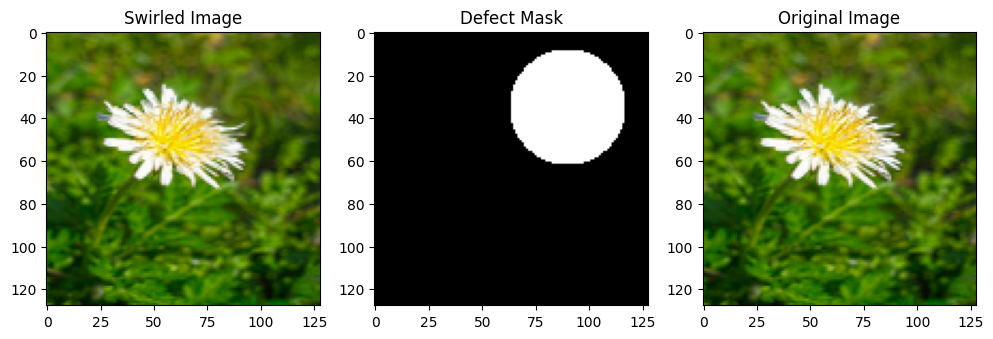

In [10]:
# Sanity check
idx = np.random.randint(0, len(test_gen) - 1)
x_batch, y_mask, y_clean = test_gen[idx]
print(y_clean.shape)
y_clean = y_clean[:,:,:,0:3]

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(x_batch[0])
plt.title("Swirled Image")

plt.subplot(1, 3, 2)
plt.imshow(y_mask[0].squeeze(), cmap='gray')
plt.title("Defect Mask")

plt.subplot(1, 3, 3)
plt.imshow(y_clean[0])
plt.title("Original Image")
plt.show()


# My Network

In [11]:
# Check for GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Using GPU: {gpus}")
else:
    print("No GPU found. Using CPU.")


Using GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [12]:
from tensorflow.keras import layers, Model

# My Network


# Architecture
def build_unet(img_shape=(IMG_SIZE, IMG_SIZE, 3), mask_shape=(IMG_SIZE, IMG_SIZE, 1)):
    inp_img = layers.Input(shape=img_shape, name="input_image")
    inp_mask = layers.Input(shape=mask_shape, name="input_mask")

    # Concatenate image and mask into a 4-channel input
    x = layers.Concatenate(axis=-1)([inp_img, inp_mask])  # (H, W, 4)

    # Encoder
    c1 = layers.Conv2D(32, 3, padding="same", activation="relu")(x)
    p1 = layers.MaxPool2D()(c1)

    c2 = layers.Conv2D(64, 3, padding="same", activation="relu")(p1)
    p2 = layers.MaxPool2D()(c2)

    # Bottleneck
    b = layers.Conv2D(128, 3, padding="same", activation="relu")(p2)

    # Decoder
    u1 = layers.UpSampling2D()(b)
    u1 = layers.Concatenate()([u1, c2])
    u1 = layers.Conv2D(64, 3, padding="same", activation="relu")(u1)
    u2 = layers.UpSampling2D()(u1)
    u2 = layers.Concatenate()([u2, c1])
    u2 = layers.Conv2D(32, 3, padding="same", activation="relu")(u2)

    # Output
    out = layers.Conv2D(3, 1, activation="sigmoid")(u2)

    return Model([inp_img, inp_mask], out, name="SwirlCorrectionUNet")


model = build_unet()
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
model.summary()

Model: "SwirlCorrectionUNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_mask          │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128, 128,  │          0 │ input_image[0][0… │
│ (Concatenate)       │ 4)                │            │ input_mask[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,184 │ concatenate[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 64, 64,    │          0 │ conv2d_2[0][0]    │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 64, 64,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 192)              │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    110,656 │ concatenate_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 128, 128,  │          0 │ conv2d_3[0][0]    │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 128, 128,  │          0 │ up_sampling2d_1[… │
│ (Concatenate)       │ 96)               │            │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │     27,680 │ concatenate_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │         99 │ conv2d_4[0][0]    │
│                     │ 3)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 231,971 (906.14 KB)

 Trainable params: 231,971 (906.14 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# TRAINING


def wrap_generator_for_fit(generator):
    """Wrap SwirlDefectGenerator to return ((x, mask), clean) for model.fit"""

    class Wrapped(tf.keras.utils.Sequence):
        def __init__(self, base):
            self.base = base

        def __len__(self):
            return len(self.base)

        def __getitem__(self, idx):
            x, mask, clean = self.base[idx]
            # x: (B, H, W, 3), mask: (B, H, W, 1)
            return (x, mask), clean  # model expects 2 inputs

        def on_epoch_end(self):
            self.base.on_epoch_end()

    return Wrapped(generator)


train_seq = wrap_generator_for_fit(train_gen)
val_seq = wrap_generator_for_fit(val_gen)

history = model.fit(train_seq, validation_data=val_seq, epochs=10)

Epoch 1/10


/home/enrico/Desktop/Swirl-Correction/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1751964330.230168   56311 service.cc:152] XLA service 0x7cacac00d540 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751964330.230185   56311 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2025-07-08 10:45:30.265518: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1751964330.383849   56311 cuda_dnn.cc:529] Loaded cuDNN version 90300


 3/93 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 0.0945 - mae: 0.2683 

I0000 00:00:1751964338.049408   56311 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


93/93 ━━━━━━━━━━━━━━━━━━━━ 20s 121ms/step - loss: 0.0416 - mae: 0.1537 - val_loss: 0.0061 - val_mae: 0.0523
Epoch 2/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step - loss: 0.0059 - mae: 0.0519 - val_loss: 0.0033 - val_mae: 0.0369
Epoch 3/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step - loss: 0.0031 - mae: 0.0363 - val_loss: 0.0022 - val_mae: 0.0296
Epoch 4/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step - loss: 0.0022 - mae: 0.0305 - val_loss: 0.0018 - val_mae: 0.0256
Epoch 5/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - loss: 0.0017 - mae: 0.0253 - val_loss: 0.0016 - val_mae: 0.0236
Epoch 6/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - loss: 0.0016 - mae: 0.0235 - val_loss: 0.0015 - val_mae: 0.0222
Epoch 7/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - loss: 0.0015 - mae: 0.0229 - val_loss: 0.0018 - val_mae: 0.0271
Epoch 8/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - loss: 0.0015 - mae: 0.0224 - val_loss: 0.0014 - val_mae: 0.0218
Epoch 9/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - loss: 0.0013 - mae: 

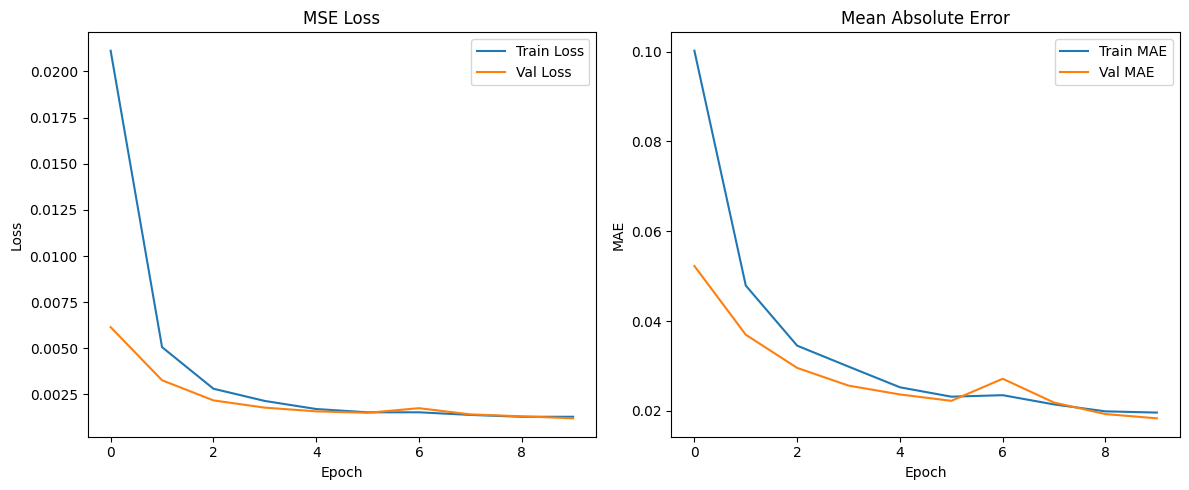

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


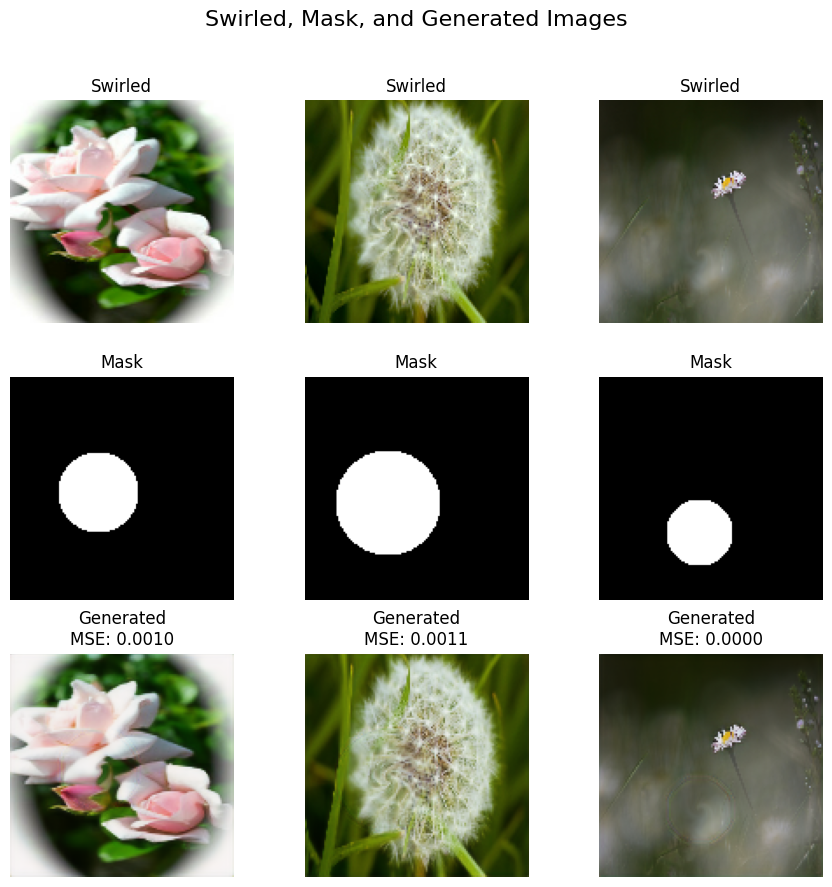

In [14]:
import matplotlib.pyplot as plt

# Plot loss and MAE
def plot_training(history):
    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('MSE Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # MAE
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Val MAE')
    plt.title('Mean Absolute Error')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()

    plt.tight_layout()
    plt.show()

def visualize_predictions(model, test_gen, n_samples=5):
    x_batch, y_mask, y_clean = test_gen[0]
    generated_images = model.predict([x_batch, y_mask])
    generated_mes_batch = np.mean((generated_images - y_clean) ** 2 * y_mask, axis=(1, 2, 3))

    n_samples = min(n_samples, len(x_batch))  # Clamp to batch size

    plt.figure(figsize=(3 * n_samples, 9))

    for i in range(n_samples):
        # Swirled image
        plt.subplot(3, n_samples, i + 1)
        plt.imshow(x_batch[i])
        plt.title("Swirled")
        plt.axis('off')

        # Mask
        plt.subplot(3, n_samples, n_samples + i + 1)
        plt.imshow(y_mask[i].squeeze(), cmap='gray')
        plt.title("Mask")
        plt.axis('off')

        # Generated
        plt.subplot(3, n_samples, 2 * n_samples + i + 1)
        plt.imshow(generated_images[i])
        plt.title(f"Generated\nMSE: {generated_mes_batch[i]:.4f}")
        plt.axis('off')

    plt.tight_layout()
    plt.suptitle("Swirled, Mask, and Generated Images", fontsize=16)
    plt.subplots_adjust(top=0.88)
    plt.show()


plot_training(history)
visualize_predictions(model, test_gen, n_samples=3)


As you may see from the examples, the swirl is not always easily identifiable by a human. The network can locate it quite easily (you may try if you like); the actual challenge consists in correcting the effect.

A pipilene of multiple networks may be acceptable. You should not rely on the knowledge that the defect was due to a swirl.

# Evaluation metric

The generated image should be evaluated ONLY on the region corresponding to the mask. In addition this will be compared with the initial distance introduced by the swirl operation

Let us compute this "initial" error:

In [15]:
# Select a batch from the test generator
idx = np.random.randint(0, len(test_gen) - 1)
x_batch_defected, x_batch_mask, y_batch_clean = test_gen[idx]
# Compute initial distance between swirled image and original for the batch
initial_mse_imgs = np.mean((x_batch_defected - y_batch_clean)**2*x_batch_mask,axis=(1,2,3))
initial_mse_batch = np.mean(initial_mse_imgs)
print(f"Initial error introduced by swilr: {initial_mse_batch:.4f}")

Initial error introduced by swilr: 0.0009


The initial error quite low. To better emphasize the correction we compute the ratio between the resulting error and the initial one.
**This should be a value between 0 (perfect reconstruction) and 1 (no reconstruction). Higher values mean you are doing things worse.**

In [21]:
# Predict the repaired images
generated_images = model.predict([x_batch_defected, x_batch_mask])

# Compute the distance between generated image and original for the batch
generated_mes_batch = np.mean((generated_images - y_batch_clean)**2*x_batch_mask,axis=(1,2,3))
# Now let us compute the ratio, and the average over the batch
mean_ratio = np.mean(generated_mes_batch/initial_mse_batch)

print(f"Average score (Generated / Initial): {mean_ratio:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Average score (Generated / Initial): 1.0024


Repeat the previous computation for all batches in testing data, and return mean and standard deviation.

In [24]:
# Repeat the computation for all the test data
all_ratios = []
for batch_idx in range(len(test_gen)):
    x_def, x_mask, y_clean = test_gen[batch_idx]
    # initial MSE (per image, only over the mask)
    init_mse = np.mean((x_def - y_clean)**2 * x_mask, axis=(1,2,3))
    # predict
    pred = model.predict([x_def, x_mask], verbose=0)
    # generated MSE
    gen_mse = np.mean((pred - y_clean)**2 * x_mask, axis=(1,2,3))
    # ratio
    all_ratios.extend((gen_mse / init_mse).tolist())

mean_ratio = np.mean(all_ratios)
std_ratio  = np.std(all_ratios)
print(f"Reconstruction Ratio over entire test set: ")
print(f"Mean: {mean_ratio:.4f}")
print(f"Std: {std_ratio:.4f}")

Reconstruction Ratio over entire test set: 
Mean: 1.4950
Std: 3.4594


# Parameters

Try to keep below 4M parameters (total, excluding parameteres of the optimizer).

You have the usual constraints:
* the project should be written in keras
* you should submit a single well documented notebook
* try to give access to weights through gdown


